# NEA TAKSI PRAGMATON

In [ ]:
from src.models.mlselection import MLSelector
from src.models.mlestimator import MachineLearningEstimator
from src.models.mlexplain import MLExplainer
from src.data.exploration import DataExplorer

%load_ext autoreload
%autoreload 2
%matplotlib inline

csv_dir = ['data/processed/epic_lc_ms_pos.csv', 'data/processed/epic_composite.csv']
label = ['group','Factor1']

features_set = [
    [
        '942.9824_0.57',
        '613.4767_25.19',
        '467.3822_23.01',
        '393.3454_25.66',
        '379.3289_23.95',
        '388.2601_28.3',
        '152.0834_22.69',
        '569.4492_25.31',
        '451.3853_28.04',
        '1096.8222_36.35'
    ],
    [
        '942.9824_0.57',
        '613.4767_25.19',
        '379.3289_23.95',
        '467.3822_23.01',
        '147.9682_8.72',
        '393.3454_25.66',
        '388.2601_28.3',
        '166.0142_8.72',
        'Lactamide',
        'Stearic acid'
    ]
]

mle = MachineLearningEstimator(label[1], csv_dir[1])
mle.tune_cv('ElasticNet', features_set[1])

Label mapping: {0: 'CASE', 1: 'CONTROL'}
MachineLearningEstimator initialized with parameters:
Label: Factor1
CSV Directory: data/processed/epic_composite.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None
Invalid model evaluation type: ['942.9824_0.57', '613.4767_25.19', '379.3289_23.95', '467.3822_23.01', '147.9682_8.72', '393.3454_25.66', '388.2601_28.3', '166.0142_8.72', 'Lactamide', 'Stearic acid']. Using default: bayesian
Found 2662 missing values


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


✓ No feature selection needed - using all features
Hyperparameter Search:   0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
# Test 1: Compare logger behavior
import logging

# Create the same logger that MLSelector uses
mlselector_logger = logging.getLogger('src.models.mlselection')
print(f"MLSelector logger level: {mlselector_logger.level}")
print(f"MLSelector logger handlers: {mlselector_logger.handlers}")
print(f"MLSelector logger propagate: {mlselector_logger.propagate}")

# Test if this logger works directly
mlselector_logger.info("Direct test of MLSelector logger")

# Compare with root logger
root_logger = logging.getLogger()
print(f"Root logger level: {root_logger.level}")
print(f"Root logger handlers: {root_logger.handlers}")

# Test root logger
root_logger.info("Direct test of root logger")


MLSelector logger level: 0
MLSelector logger handlers: []
MLSelector logger propagate: True
Root logger level: 30
Root logger handlers: []


In [ ]:
from src.models.mlselection import MLSelector
from src.models.mlestimator import MachineLearningEstimator
from src.models.mlexplain import MLExplainer
from src.data.process import DataProcessor

%load_ext autoreload
%autoreload 2
%matplotlib inline

csv_dir = 'data/processed/chronic_fatigue.csv'
label = 'Class'

# ===========================================================
# SCRIPT 1 FOR ICC
# ===========================================================

features_list = [
        '942.9824_0.57',
        '613.4767_25.19',
        '379.3289_23.95'
    ]

prpr = DataProcessor(csv_dir=csv_dir, label=label)
prpr_paths = prpr.split_data(keep_balance=True, test_size=0.2)

mle = MachineLearningEstimator(label=label, csv_dir=prpr_paths['train_path'])
outcomes = mle.tune_cv('ElasticNet', num_features=[10, 50, None], splits=3, inner_splits=3, rounds=3)

mle_2 = MachineLearningEstimator(label=label, csv_dir=prpr_paths['test_path'])
mle_2.evaluation(model_path=outcomes['model_path'], evaluation_type='bootstrap')

mlpipe = MLSelector(label=label, csv_dir=prpr_paths['train_path'])
mlpipe.modelselection(search_on=['ElasticNet'],num_features=[10,50,None],splits=3,inner_splits=3,rounds=3)

MLSelector initialized with parameters:
Label: Class
CSV Directory: data/processed/chronic_fatigue_train.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None


KeyboardInterrupt: 

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None
MLExplainer initialized with model: None


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


CV rounds: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]
✓ Completed 20 CV rounds
✓ Evaluation completed
✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250524_143425_EVAL_CV_ROUNDS.csv
✓ SHAP values calculated
✓ Model evaluation completed
Converting SHAP values to Explanation object
Could not create specific label plot. Showing summary plot for all data.


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250524_143425_EVAL_CV_ROUNDS_plot.png


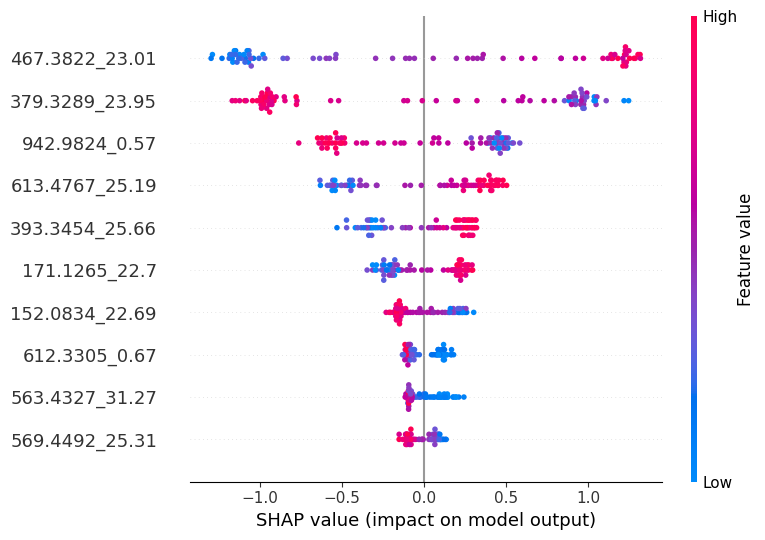

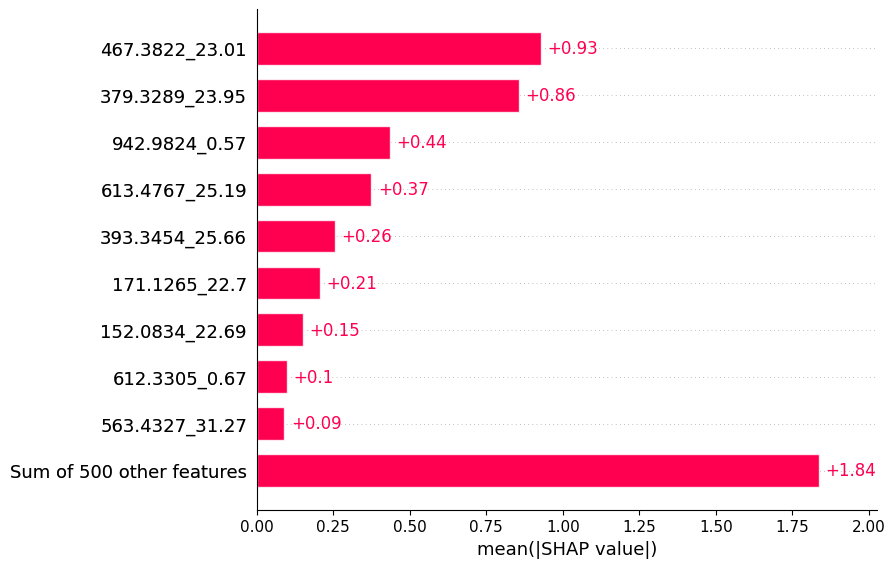

Created bar plot for SHAP values


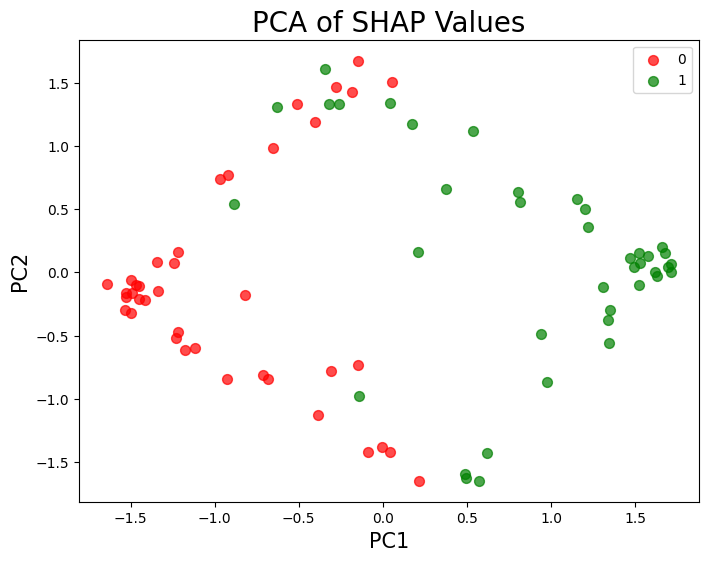

In [ ]:
# models = [
#     # 'results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_20250523_102711_TUNE_BAYESIAN_model.pkl',
#     # 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_20250523_112041_TUNE_BAYESIAN_model.pkl',
#     'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_20250524_142829_TUNE_BAYESIAN_model.pkl'
#     ]
# for model in models:
#     mle = MLExplainer(label[0],csv_dir[0])
#     mle.evaluation(model_path = model, scoring='roc_auc', calculate_shap=True)#, features_name_list=features_set[0])
#     mle.plot_shap_values()#features_name_list=features_set[0]
#     mle.plot_shap_values(plot_type='bar')
#     mle.plot_shap_pca()

In [30]:
mle.shap_values

.values =
array([[-5.61036958e-02,  1.03931886e-01, -6.60036679e-02,
        -2.92959097e-01, -2.10238673e-01,  1.19563623e-02,
        -1.35405513e-01, -3.82716264e-02, -6.83465158e-02,
        -1.46722398e-02],
       [ 1.05614510e-01, -1.91773777e-01,  1.17898150e-01,
        -2.46655793e-01, -1.40799511e-01, -1.40927396e-01,
        -7.62995581e-02,  1.22385986e-01, -5.91661150e-02,
        -7.46267361e-02],
       [-8.00173040e-02, -1.35131446e-01, -2.62727670e-01,
        -9.22117880e-02,  2.24573656e-01, -2.02812007e-01,
        -9.21779004e-02,  9.80262814e-02, -7.74886038e-02,
        -2.24752619e-02],
       [-1.03142919e-01,  6.64219900e-02,  1.88874001e-01,
        -3.44479866e-01, -1.57578153e-01,  8.29803931e-02,
         1.41522559e-02, -4.50105993e-02,  1.64613242e-02,
         1.25649923e-01],
       [-2.87166827e-01,  2.60337645e-01, -1.35192350e-01,
        -2.02090939e-01, -2.41761442e-01,  1.46456923e-01,
        -9.47059938e-02, -1.26615096e-01,  7.12725721e-02,
 

In [13]:
mle = MachineLearningEstimator(label[0],csv_dir[0])
model = [
'results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_20250523_102711_TUNE_BAYESIAN_model.pkl',
'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_20250523_112041_TUNE_BAYESIAN_model.pkl',
'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_20250523_111447_TUNE_BAYESIAN_model.pkl'

]
eval_list = ['cv_rounds','oob','bootstrap']
for model_p in model:
    print(f"Evaluating {model}...")
    for eval_mthd in eval_list:
        print(f"Evaluating {eval_mthd}...")
        mle.evaluation(model_path = model_p, evaluation=eval_mthd, scoring='roc_auc')

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}
Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_20250523_102711_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_20250523_112041_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_20250523_111447_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_130921_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_130921_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131046_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131046_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131159_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131159_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_20250523_102711_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_20250523_112041_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_20250523_111447_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_131257_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_131257_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131310_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131310_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131333_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131333_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_20250523_102711_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_20250523_112041_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_20250523_111447_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_131356_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_cv_rounds_20250523_131356_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131621_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_oob_20250523_131621_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [02:13<00:00,  1.33s/it]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131907_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_evaluation_bootstrap_20250523_131907_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


In [14]:
mle = MachineLearningEstimator(label[0],csv_dir[0])
model = [
'results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120727_TUNE_BAYESIAN_model.pkl',
'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120845_TUNE_BAYESIAN_model.pkl',
'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120853_TUNE_BAYESIAN_model.pkl'

]
eval_list = ['cv_rounds','oob','bootstrap']
for model_p in model:
    print(f"Evaluating {model}...")
    for eval_mthd in eval_list:
        print(f"Evaluating {eval_mthd}...")
        mle.evaluation(model_path = model_p, evaluation=eval_mthd, scoring='roc_auc', features_name_list=features_set[0])

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}
Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120727_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120845_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120853_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132120_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132120_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [00:04<00:00, 21.49it/s]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132126_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132126_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132131_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132131_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120727_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120845_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120853_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132135_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132135_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [00:01<00:00, 83.12it/s]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132137_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132137_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [00:01<00:00, 83.51it/s]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132138_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132138_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


Evaluating ['results/models/epic_lc_ms_pos_CatBoostClassifier_estimator_name_CatBoostClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120727_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_ElasticNet_estimator_name_ElasticNet_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120845_TUNE_BAYESIAN_model.pkl', 'results/models/epic_lc_ms_pos_XGBClassifier_estimator_name_XGBClassifier_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_20250523_120853_TUNE_BAYESIAN_model.pkl']...
Evaluating cv_rounds...


✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132140_EVAL_CV_ROUNDS_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_cv_rounds_20250523_132140_EVAL_CV_ROUNDS.csv
✓ Model evaluation completed


Evaluating oob...


OOB validation: 100%|██████████| 100/100 [00:06<00:00, 15.78it/s]
✓ OOB validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132147_EVAL_OOB_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_oob_20250523_132147_EVAL_OOB.csv
✓ Model evaluation completed


Evaluating bootstrap...


Bootstrap validation: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]
✓ Bootstrap validation complete
✓ Evaluation completed


✓ Plot saved as: results/images/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132154_EVAL_BOOTSTRAP_plot.png


✓ Results saved to results/csv/model_evaluation/epic_lc_ms_pos_None_scoring_roc_auc_features_name_list_942.9824_0.57_613.4767_25.19_467.3822_23.01_etc_evaluation_bootstrap_20250523_132154_EVAL_BOOTSTRAP.csv
✓ Model evaluation completed


In [2]:
# from src.data.dataloader import DataLoader
# from src.data.exploration import DataExplorer
from src.models.mlselection import MLSelector
from src.models.mlestimator import MachineLearningEstimator

%load_ext autoreload
%autoreload 2
%matplotlib inline

csv_dir = 'data/processed/epic_lc_ms_pos.csv'
label = 'group'
    
# mlexp = MLSelector(csv_dir=csv_dir, label=label, normalization='minmax', database_name='test.db')
# df = mlexp.modelselection(search_on=['ElasticNet','LogisticRegression', 'RandomForestClassifier'], num_features=[10,11,14,None], rounds=2, inner_splits=2, splits=2, n_trials=5,sfm=True, info_to_db=True)
# mlexp = MLSelector(csv_dir=csv_dir, label=label, normalization='standard', database_name='test.db', inner_selection=["validation_score", "one_sem"])
# df = mlexp.modelselection(search_on=['LogisticRegression', 'RandomForestClassifier'],  num_features=[11,14], rounds=2, inner_splits=2, splits=2, n_trials=15,sfm=True, info_to_db=True)
ml = MachineLearningEstimator(csv_dir=csv_dir, label=label)
# ml.tune_cv(estimator_name='CatBoostClassifier')
# ml.search_cv(estimator_name='ElasticNet', info_to_db=True,calculate_shap=True, n_trials=5)
# ml.search_cv(estimator_name='LogisticRegression', info_to_db=True,calculate_shap=True, n_trials=5, search_type='random')
# ml.search_cv(estimator_name='LogisticRegression', info_to_db=True,calculate_shap=True, n_trials=5, search_type='grid')
# ml.search_cv(estimator_name='RandomForestClassifier', info_to_db=True,calculate_shap=True, n_trials=5, sfm=True, num_features=10)

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


In [3]:
# import json 
# with open('results/json/chronic_fatigue_rounds_2_n_trials_5_inner_splits_2_splits_2_sfm_True_20250522_105957_MS_BOTH_frfs.json') as f:
#     data = json.load(f)
# print(data['ElasticNet_10']['features'])
features = [
    '942.9824_0.57',
    '613.4767_25.19',
    '467.3822_23.01',
    '393.3454_25.66',
    '379.3289_23.95',
    '388.2601_28.3',
    '152.0834_22.69',
    '569.4492_25.31',
    '451.3853_28.04',
    '1096.8222_36.35'
]
ml.tune_cv(estimator_name='CatBoostClassifier', features_name_list=features)

✓ Selected 10 features from provided list
✓ Applied minmax normalization
✓ Filled missing values using median
[I 2025-05-23 12:07:27,132] A new study created in memory with name: no-name-9840a649-1f7b-4a64-b384-9090fe3b839f


[I 2025-05-23 12:07:27,737] Trial 19 finished with value: 0.9527668414752787 and parameters: {'n_estimators': 123, 'learning_rate': 0.024891655935735453, 'depth': 5, 'l2_leaf_reg': 1.518337964519236, 'border_count': 187, 'bagging_temperature': 6.311115032808479, 'random_strength': 4.175287509523083, 'leaf_estimation_method': 'Newton', 'verbose': 0, 'model_size_reg': 0.04049420197023638, 'min_data_in_leaf': 7, 'thread_count': 1, 'loss_function': 'CrossEntropy'}. Best is trial 19 with value: 0.9527668414752787.
[I 2025-05-23 12:07:28,068] Trial 16 finished with value: 0.8588719645272663 and parameters: {'n_estimators': 97, 'learning_rate': 0.1472881340214862, 'depth': 7, 'l2_leaf_reg': 0.6544101487362715, 'border_count': 171, 'bagging_temperature': 0.993803613080263, 'random_strength': 4.117875190451814, 'leaf_estimation_method': 'Newton', 'verbose': 0, 'model_size_reg': 0.5101528297868557, 'min_data_in_leaf': 9, 'thread_count': 1, 'loss_function': 'Logloss'}. Best is trial 19 with value

In [4]:

ml = MachineLearningEstimator(csv_dir=csv_dir, label=label)
# ml.tune_cv(estimator_name='ElasticNet')
features = [
    '942.9824_0.57',
    '613.4767_25.19',
    '467.3822_23.01',
    '393.3454_25.66',
    '379.3289_23.95',
    '388.2601_28.3',
    '152.0834_22.69',
    '569.4492_25.31',
    '451.3853_28.04',
    '1096.8222_36.35'
]
ml.tune_cv(estimator_name='ElasticNet', features_name_list=features)

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None
[I 2025-05-23 12:08:45,661] A new study created in memory with name: no-name-e5e2e3f7-2274-4b19-bba2-a1b3a1db0d98


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


[I 2025-05-23 12:08:45,866] Trial 0 finished with value: 0.8488001498359532 and parameters: {'penalty': 'elasticnet', 'C': 0.5839464413289487, 'solver': 'saga', 'max_iter': 991, 'n_jobs': None, 'l1_ratio': 0.5012432829637764}. Best is trial 0 with value: 0.8488001498359532.
[I 2025-05-23 12:08:45,902] Trial 2 finished with value: 0.7787159756617998 and parameters: {'penalty': 'elasticnet', 'C': 0.917982601389835, 'solver': 'saga', 'max_iter': 822, 'n_jobs': None, 'l1_ratio': 0.8087086309202378}. Best is trial 0 with value: 0.8488001498359532.
[I 2025-05-23 12:08:45,957] Trial 1 finished with value: 0.8777313260145074 and parameters: {'penalty': 'elasticnet', 'C': 0.847549033020619, 'solver': 'saga', 'max_iter': 516, 'n_jobs': None, 'l1_ratio': 0.2484778821394663}. Best is trial 1 with value: 0.8777313260145074.
[I 2025-05-23 12:08:46,309] Trial 4 finished with value: 0.7853976295326797 and parameters: {'penalty': 'elasticnet', 'C': 0.5466279051045398, 'solver': 'saga', 'max_iter': 1293

In [5]:
ml = MachineLearningEstimator(csv_dir=csv_dir, label=label)
# ml.tune_cv(estimator_name='XGBClassifier')
features = [
    '942.9824_0.57',
    '613.4767_25.19',
    '467.3822_23.01',
    '393.3454_25.66',
    '379.3289_23.95',
    '388.2601_28.3',
    '152.0834_22.69',
    '569.4492_25.31',
    '451.3853_28.04',
    '1096.8222_36.35'
]
ml.tune_cv(estimator_name='XGBClassifier', features_name_list=features)

MachineLearningEstimator initialized with parameters:
Label: group
CSV Directory: data/processed/epic_lc_ms_pos.csv
Index Column: None
Normalization: minmax
Feature Selection Method: mrmr
Missing Values Method: median
Database Name: None
[I 2025-05-23 12:08:53,249] A new study created in memory with name: no-name-f35869fa-baf6-45a1-9e93-3fe27e9aa683


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


[I 2025-05-23 12:08:54,662] Trial 13 finished with value: 0.8281316797998665 and parameters: {'learning_rate': 0.02861512836334533, 'n_estimators': 75, 'max_depth': 10, 'subsample': 0.5574540881729741, 'n_jobs': 1, 'booster': 'dart', 'tree_method': 'exact', 'reg_alpha': 0.3767062884688497, 'reg_lambda': 0.943855959961325, 'objective': 'binary:logistic', 'eval_metric': 'error'}. Best is trial 13 with value: 0.8281316797998665.
[I 2025-05-23 12:08:54,689] Trial 15 finished with value: 0.9019154658528665 and parameters: {'learning_rate': 0.19697038685914922, 'n_estimators': 81, 'max_depth': 4, 'subsample': 0.8915390905499221, 'n_jobs': 1, 'booster': 'gbtree', 'tree_method': 'approx', 'reg_alpha': 0.0039327077462375515, 'reg_lambda': 0.5927491637357771, 'objective': 'binary:logistic', 'eval_metric': 'error'}. Best is trial 15 with value: 0.9019154658528665.
[I 2025-05-23 12:08:54,791] Trial 2 finished with value: 0.902143522130124 and parameters: {'learning_rate': 0.1170979787948822, 'n_es

In [ ]:
import pickle
import glob
import os

features = [None, ['942.9824_0.57','613.4767_25.19','379.3289_23.95','467.3822_23.01','147.9682_8.72','393.3454_25.66','388.2601_28.3','Lactamide','Stearic acid','615.3697_19.2']]

# Find all .pkl files in the directory
pkl_files = glob.glob("results/models/*.pkl")

# Loop through each .pkl file
for pkl_file in pkl_files:
    for feature in features:
        ml.evaluation(model_path=pkl_file, features_name_list=features)

In [33]:
pp = AI4METAPipeline(
    csv_dir=csv_dir,
    label=label
)

In [34]:
pp.search_cv(estimator_name='ElasticNet',calculate_shap=True)

✓ Using default parameter grid


✓ Completed Bayesian optimization
✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Results saved to results/csv/chronic_fatigue_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_29_20250512_1523_bayesian_search_final_model.csv
✓ Model saved to results/models/chronic_fatigue_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_29_20250512_1523_bayesian_search_final_model.pkl
✓ Best hyperparameters saved to results/models/chronic_fatigue_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_29_20250512_1523_bayesian_search_best_params.json
✓ Metadata of the function saved to results/models/chronic_fatigue_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_29_20250512_1523_bayesian_search_metadata.json
✓ Model selection and evaluation complete


'Done'

In [37]:
pp.plot_shap_values()

AttributeError: 'MLExplainer' object has no attribute 'shap_values'

In [ ]:
pp.

In [16]:
from src.models.mlselection import MLPipelines
csv_dir = 'data/processed/epic_composite.csv'
label = 'Factor1'

mlp = MLPipelines(csv_dir=csv_dir, label=label)
mlp.rcv_accel(rounds=2, splits=3,search_on=['ElasticNet'])

✓ Applied minmax normalization to train and test sets
✓ Applied minmax normalization to train and test sets
✓ Filled missing values using median
✓ Filled missing values using median
✓ No feature selection needed - using all features
✓ No class balancing requested, returning original data
✓ No feature selection needed - using all features
✓ No class balancing requested, returning original data
Round 2 of CV:  0% |                     | Elapsed Time: 0:00:00 ETA:  --:--:--
Round 1 of CV:  0% |                     | Elapsed Time: 0:00:00 ETA:  --:--:--
Round 1 of CV: 33% |███████              | Elapsed Time: 0:00:01 ETA:   0:00:02
Round 2 of CV: 33% |███████              | Elapsed Time: 0:00:01 ETA:   0:00:02
Round 1 of CV: 66% |██████████████       | Elapsed Time: 0:00:02 ETA:   0:00:01
Round 2 of CV: 66% |██████████████       | Elapsed Time: 0:00:02 ETA:   0:00:01
Round 1 of CV:100% |█████████████████████| Elapsed Time: 0:00:02 Time:  0:00:02
Round 2 of CV:100% |█████████████████████| E

Completed round 1 in 0.00 hours
Completed round 2 in 0.00 hours
Results saved to: results/csv/epic_composite_rounds_2_scoring_roc_auc_splits_3_20250512_1239_rcv_outerloops_results.csv


,Est,Sel_way,Fs_num,Norm,Miss_vals,Splits,Rnds,In_sel,AUC_mean,AUC_std,...,AVG_PREC_lomed,AVG_PREC_upmed,SPEC_mean,SPEC_std,SPEC_sem,SPEC_med,SPEC_lomean,SPEC_upmean,SPEC_lomed,SPEC_upmed
0,ElasticNet,none,1430,minmax,median,3,2,Validation_score,0.885,0.054,...,0.875,0.953,0.872,0.085,0.038,0.885,0.808,0.936,0.769,0.962


In [23]:
mod,df,shap = mlp.search_cv(estimator_name='ElasticNet',calculate_shap=True, num_features=10)

✓ Selected 10 features using mrmr
✓ Completed 20 CV rounds
✓ Evaluation completed


✓ Results saved to results/csv/epic_composite_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250512_1244_bayesian_search_final_model.csv
✓ Model saved to results/models/epic_composite_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250512_1244_bayesian_search_final_model.pkl
✓ Best hyperparameters saved to results/models/epic_composite_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250512_1244_bayesian_search_best_params.json
✓ Metadata of the function saved to results/models/epic_composite_rounds_20_estimator_name_ElasticNet_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250512_1244_bayesian_search_metadata.json


In [24]:
from src.models.mlexplain import MLExplainer
expl = MLExplainer(mod, mlp.X, mlp.y ,mlp.label_mapping, shap_values=shap)
expl.plot_shap_values()

The SHAP values do not exist for the label 1. Showing summary plot for all labels.


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

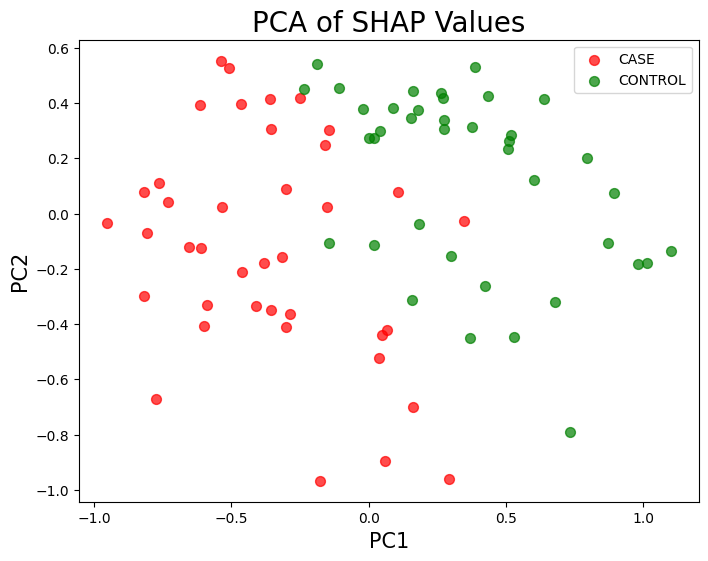

In [22]:
expl.plot_shap_pca()

### OLD

In [74]:
from src.models.mlselection import MLPipelines
from src.models.mlexplain import MLExplainer
from src.models.mlestimator import MachineLearningEstimator

%load_ext autoreload
%autoreload 2
%matplotlib inline

csv_dir = 'data/processed/epic_composite.csv'
label = 'Factor1'

mlpipe = MachineLearningEstimator(label=label, csv_dir=csv_dir)
mlpipe.search_cv(scoring='roc_auc', estimator_name='CatBoostClassifier', num_features=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


✓ Completed 20 CV rounds
✓ Evaluation completed
/home/spyros/Desktop/AI4META/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



✓ Results saved to results/csv/epic_composite_scoring_roc_auc_rounds_20_estimator_name_CatBoostClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250508_1716_bayesian_search_final_model.csv
✓ Model saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_CatBoostClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250508_1716_bayesian_search_final_model.pkl
✓ Best hyperparameters saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_CatBoostClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250508_1716_bayesian_search_best_params.json
✓ Metadata of the function saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_CatBoostClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_10_20250508_1716_bayesian_search_metadata.json


(<catboost.core.CatBoostClassifier at 0x72a3a6371750>,
     roc_auc  accuracy  balanced_accuracy  recall  precision        f1  \
 0       1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 1       1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 2       1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 3       1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 4       1.0  0.933333           0.928571     1.0   0.888889  0.941176   
 ..      ...       ...                ...     ...        ...       ...   
 95      1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 96      1.0  0.937500           0.937500     1.0   0.888889  0.941176   
 97      1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 98      1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 99      1.0  1.000000           1.000000     1.0   1.000000  1.000000   
 
     average_precision  specificity  matthews_corrcoef 

The SHAP values do not exist for the label 1. Showing summary plot for all labels.


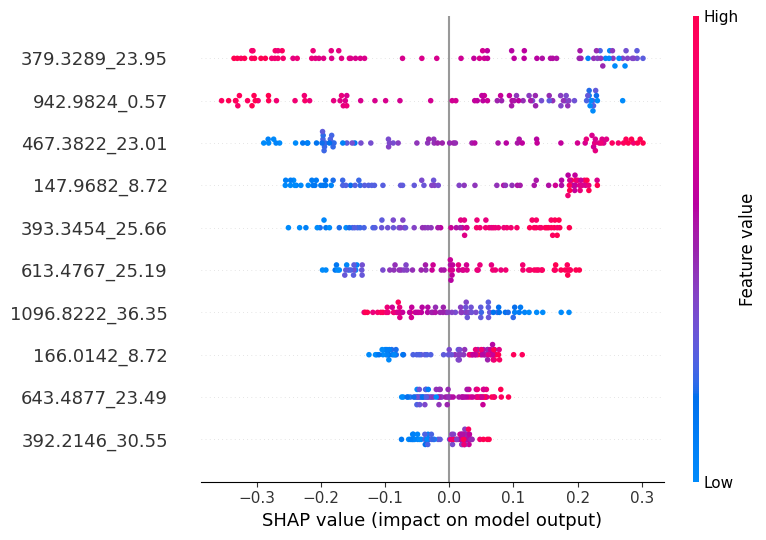

In [76]:
X_normalized = mlpipe.normalize(mlpipe.X)
features = mlpipe.feature_selection(X_normalized,mlpipe.y,num_features=10)
X_normalized = X_normalized[features]
X_normalized = mlpipe.missing_values(X_normalized)
fit_model = mlpipe.best_estimator.fit(X_normalized, mlpipe.y)

explainer = MLExplainer(fit_model,X_normalized, mlpipe.y ,mlpipe.label_mapping)
explainer.calculate_shap_values()
explainer.plot_shap_values()

In [68]:
csv_dir = 'data/processed/epic_composite.csv'
label = 'Factor1'

mlpipe = MachineLearningEstimator(label=label, csv_dir=csv_dir)

model, df, shap = mlpipe.search_cv(scoring='roc_auc', estimator_name='XGBClassifier',calculate_shap=True)#

explainer = MLExplainer(model, mlpipe.X, mlpipe.y, mlpipe.label_mapping, shap_values=shap)

✓ Completed 20 CV rounds
✓ Evaluation completed
/home/spyros/Desktop/AI4META/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



✓ Results saved to results/csv/epic_composite_scoring_roc_auc_rounds_20_estimator_name_XGBClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_1430_20250508_1710_bayesian_search_final_model.csv
✓ Model saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_XGBClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_1430_20250508_1710_bayesian_search_final_model.pkl
✓ Best hyperparameters saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_XGBClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_1430_20250508_1710_bayesian_search_best_params.json
✓ Metadata of the function saved to results/models/epic_composite_scoring_roc_auc_rounds_20_estimator_name_XGBClassifier_evaluation_cv_rounds_inner_selection_validation_score_features_name_1430_20250508_1710_bayesian_search_metadata.json


In [63]:
shap.shape

(78, 10)

The SHAP values do not exist for the label 1. Showing summary plot for all labels.


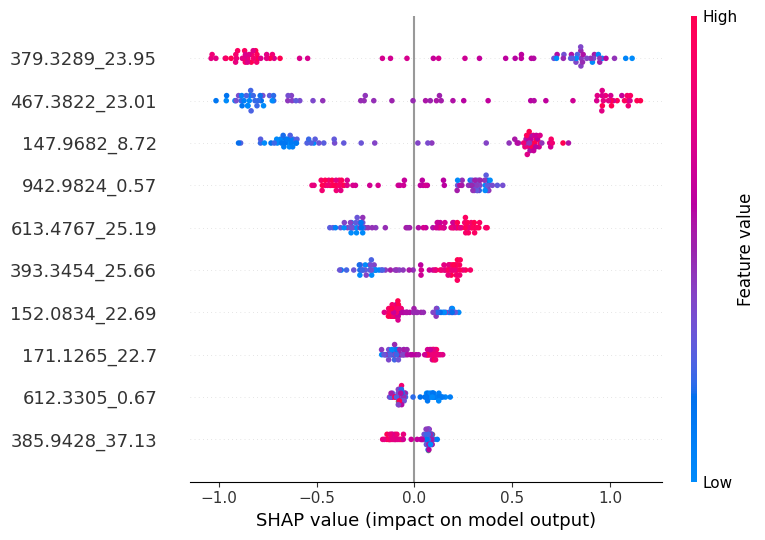

In [69]:
explainer.plot_shap_values()

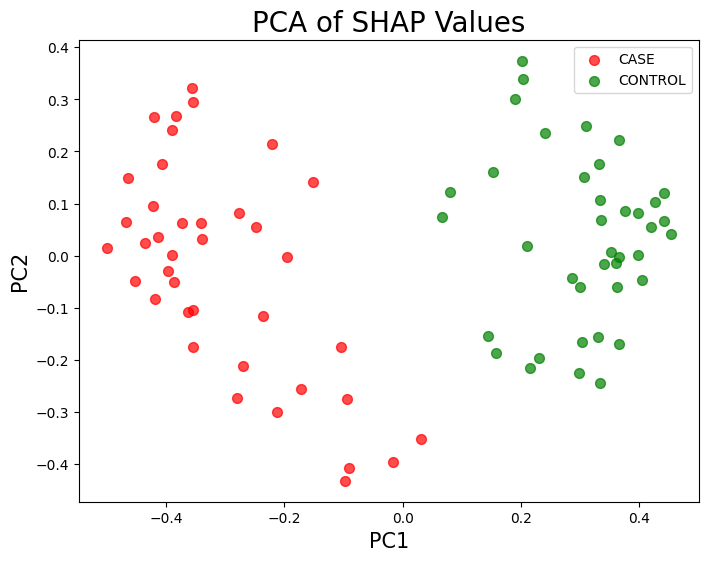

In [77]:
explainer.plot_shap_pca()

In [ ]:

# for class_blnc in ['auto','smote_enn','smot---','tomek','borderline_smote']:
#     print(class_blnc)
# filter_csv = {'MCC_mean':{'h': 0}}

# df = mlpipe.nested_cv(parallel = 'freely_parallel', rounds=3,n_trials=20,outer_splits=3,inner_splits=3,num_features=1,searc=h_on=[ 'ElasticNet'],info_to_db=True)
# # df = mlpipe.nested_cv(rounds=2,n_trials=20,outer_splits=3,inner_splits=3,parallel='freely_parallel',search_on=['ElasticNet'],num_features=[1,mlpipe.X.shape[1]], info_to_db=False, return_csv=False)
# mlpipe.rcv_accel(rounds=3,splits=5,num_features=[1,mlpipe.X.shape[1]], sfm=True, search_on=['RandomForestClassifier','ElasticNet'], info_to_db=True)



In [5]:
sc

,matthews_corrcoef,roc_auc,accuracy,balanced_accuracy,recall,precision,f1
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.881917,0.937500,0.937500,0.937500,0.875000,1.000000,0.933333
2,0.881917,0.937500,0.937500,0.937500,1.000000,0.888889,0.941176
3,0.755929,0.857143,0.866667,0.857143,0.714286,1.000000,0.833333
4,0.872872,0.928571,0.933333,0.928571,1.000000,0.888889,0.941176
5,0.881917,0.937500,0.937500,0.937500,1.000000,0.888889,0.941176
6,0.629941,0.812500,0.812500,0.812500,0.875000,0.777778,0.823529
7,0.881917,0.937500,0.937500,0.937500,1.000000,0.888889,0.941176
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df = mlpipe.nested_cv(rounds=4,n_trials_ncv=30,outer_splits=4,inner_splits=4,parallel='freely_parallel',num_features=[1,4,20,mlpipe.X.shape[1]], frfs=True, search_on=['LogisticRegression','ElasticNet','LinearDiscriminantAnalysis'], show_bad_samples=True,name_add='manolakos_test', info_to_db=True)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x73915ff9af20>
Traceback (most recent call last):
  File "/home/spyros/Desktop/AI4META/venv/lib/python3.11/site-packages/threadpoolctl.py", line 1005, in match_library_callback
  File "/home/spyros/Desktop/AI4META/venv/lib/python3.11/site-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
  File "/home/spyros/Desktop/AI4META/venv/lib/python3.11/site-packages/threadpoolctl.py", line 114, in __init__
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /home/spyros/Desktop/AI4META/venv/lib/python3.11/site-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolControl

Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.
The num_features parameter is [1, 4, 20, 149].
The result will be a Dataframe and a List with the freq_feat number of the most important features.
If the freq_feat is None, the result will be a List with all features.
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/spyros/Desktop/AI4META/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_73714/1667947957.py", line 1, in <module>
    df = mlpipe.nested_cv(rounds=4,n_trials_ncv=30,outer_splits=4,inner_splits=4,parallel='freely_parallel',num_features=[1,4,20,mlpipe.X.shape[1]], frfs=True, search_on=['LogisticRegression','ElasticNet','LinearDiscriminantAnalysis'], show_bad_samples=True,name_add='manolakos_test', info_to_db=True)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spyros/Desktop/AI4META/machinelearning/mlpipeline.py", line 1111, in nested_cv
    list_dfs = Parallel(n_jobs=use_cores, verbose=0)(
               ^^^^^

In [31]:
df.head()

,Estimator,Max_matthews_corrcoef,Std_matthews_corrcoef,SEM_matthews_corrcoef,Median_matthews_corrcoef,Inner_Selection,Numbers_of_Features,Way_of_Selection,Max_roc_auc,Std_roc_auc,...,SEM_f1,Median_f1,Max_average_precision,Std_average_precision,SEM_average_precision,Median_average_precision,Max_specificity,Std_specificity,SEM_specificity,Median_specificity
0,CatBoostClassifier,0.757143,0.121865,0.070359,0.566530,validation_score,149,full,0.942857,0.051715,...,0.039690,0.769231,0.932765,0.070756,0.040851,0.885393,0.857143,0.042208,0.024369,0.814935
1,ElasticNet,0.756565,0.149710,0.086435,0.515942,validation_score,149,full,0.904762,0.040108,...,0.036580,0.750591,0.918750,0.058948,0.034033,0.824656,0.904762,0.169056,0.097604,0.747835
2,GaussianNB,0.560861,0.143207,0.082681,0.341138,validation_score,149,full,0.826190,0.086578,...,0.036936,0.689723,0.832343,0.110669,0.063895,0.621291,0.809524,0.118182,0.068233,0.582251
3,GaussianProcessClassifier,0.560861,0.089486,0.051665,0.420677,validation_score,149,full,0.778571,0.059682,...,0.025734,0.707856,0.807433,0.086449,0.049911,0.727351,0.857143,0.200713,0.115882,0.677489
4,GradientBoostingClassifier,0.572078,0.070183,0.040520,0.490970,validation_score,149,full,0.873810,0.041005,...,0.028527,0.747093,0.897806,0.057488,0.033191,0.822173,0.772727,0.044583,0.025740,0.767316


In [3]:
import pandas as pd

# datasets = ['epic_lc_ms_neg']#, 'chronic_fatigue','lung_cancer','periodontal_inflammation','epic_lc_ms_pos','epic_composite']
inner_selection = ['one_sem','validation_score']#,'gso_1','gso_2','one_sem_grd']
evaluation = ['bootstrap','oob']
estimators = ['LogisticRegression', 'LinearDiscriminantAnalysis']#,'XGBClassifier','SVC','RandomForestClassifier','ElasticNet','LGBMClassifier','GradientBoostingClassifier']

# for dataset in datasets:
dataset_df_final = pd.DataFrame()
# csv_dir = 'data/' + dataset + '.csv'
# # if (dataset == 'epic_lc_ms_pos') or(dataset == 'epic_composite'):
# label = 'group'
# # else:
#     # label= 'Class' 

# mlpipe = MLPipelines(label=label, csv_dir=csv_dir)
for estimator in estimators:
    for evaluation_method in evaluation:
        for inner in inner_selection:
            mod, df = mlpipe.bayesian_search(estimator_name=estimator,scoring='matthews_corrcoef',boxplot=False, evaluation=evaluation_method, n_trials=100, cv=5, warnings_filter=True,training_method=inner,processors=4)
            dataset_df_final = pd.concat([dataset_df_final,df], ignore_index=True)
            dataset_df_final.to_csv('Final_Model_Results/' + dataset + '_final.csv')
            print(f'FINISHED WITH {dataset} AND {estimator} AND {evaluation_method} AND {inner}')

Normalization completed.
Estimator: LogisticRegression
Best parameters: {'penalty': 'l2', 'C': 0.3049859549241435, 'solver': 'sag', 'max_iter': 389, 'n_jobs': None}
Best trials score wiuth validation method: 0.6559117521646411. Using one_sem th best score is 0.6289911416376261.


Bootstrap validation: 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


NameError: name 'dataset' is not defined

In [25]:
df_oob.shape

(2, 14)

In [22]:
df  = df.explode('Scores')
df.shape

(50, 13)

In [6]:
# eda = DataExplorer(label=label, csv_dir=csv_dir)
# # feat = eda.statistical_difference(show_box=False)
# eda.pairplots_function(data=mlpipe.X, labels=mlpipe.y, num_of_best_features=6)#list_of_feature=feat)

In [5]:
from dataloader.dataloader import DataLoader

datal = DataLoader(label=label, csv_dir=csv_dir)
mrmrfeatX = datal.feature_selection(method='mrmr', num_features=6, inner_method='chi2')
print(mrmrfeatX)


None


# H-NMR urinary metabolomic profiling **Paper Validation**

In [7]:
import numpy as np
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.utils import resample
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
import plotly.express as px

import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm
import logging


level=0
optuna.logging.set_verbosity(level)
logging.getLogger("optuna").setLevel(level)

# Assuming mlpipe.X and mlpipe.y are already defined
mlpipe.X = datal.missing_values(mlpipe.X)
# mlpipe.X = mlpipe.X.fillna(0)


selected_features = ['M8','M18','M32']
X = mlpipe.X[selected_features]
# X = mlpipe.X
y = pd.DataFrame(mlpipe.y)

# Define the objective function for Optuna
def objective(trial):
#     penalty = trial.suggest_categorical('penalty', ['elasticnet'])
#     C = trial.suggest_float('C', 0.01, 1.0)
#     l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    # solver = trial.suggest_categorical('solver', ['saga'])

    alpha = trial.suggest_float('alpha', 0,1)
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    positive = trial.suggest_categorical('positive', [True, False])
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    precompute = trial.suggest_categorical('precompute', [True, False])
    
    mcc_scores = []
    
    # Bootstrap resampling and Lasso fitting
    for i in range(100):  # Assuming 100 bootstrap samples
        X_resampled, y_resampled = resample(X, y, replace=True, random_state=i)
        
        # Split the resampled data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=i)
        
        # Train the Lasso model with the suggested alpha
        lasso_classifier = Lasso(alpha=alpha, selection=selection, positive=positive, warm_start=warm_start, precompute=precompute)
        # lasso_classifier = LogisticRegression(penalty=penalty, C=C, l1_ratio=l1_ratio, solver=solver)
        lasso_classifier.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = lasso_classifier.predict(X_test)

        # Convert predictions to binary using a threshold
        y_pred_binary = np.where(y_pred > 0.5, 1, 0)
        
        # Calculate the MCC
        # mcc = roc_auc_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred_binary)
        mcc_scores.append(mcc)
    
    # Return the mean score across all bootstrap samples
    return np.mean(mcc_scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)



  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score

best_params = study.best_trial.params
# model_bootstrap = LogisticRegression(**best_params)
model_bootstrap = Lasso(**best_params)

# List to store metrics for each iteration
bootstrap_scores = {
    "roc_auc": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "matthews_corrcoef": [],
    "balanced_accuracy": [],
}

# Perform bootstrap validation
for i in tqdm.tqdm(range(100), desc="Bootstrap validation"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, shuffle=True, random_state=i
    )
    model_bootstrap.fit(X_train, y_train)
    y_pred = model_bootstrap.predict(X_test)

    # Convert predictions to binary if necessary (for classification metrics)
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]

    # Calculate and store all metrics
    bootstrap_scores["roc_auc"].append(roc_auc_score(y_test, y_pred))
    bootstrap_scores["accuracy"].append(accuracy_score(y_test, y_pred_binary))
    bootstrap_scores["precision"].append(precision_score(y_test, y_pred_binary))
    bootstrap_scores["recall"].append(recall_score(y_test, y_pred_binary))
    bootstrap_scores["f1"].append(f1_score(y_test, y_pred_binary))
    bootstrap_scores["matthews_corrcoef"].append(matthews_corrcoef(y_test, y_pred_binary))
    bootstrap_scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred_binary))

# Convert the dictionary to a DataFrame for easy plotting and analysis
bootstrap_scores_df = pd.DataFrame(bootstrap_scores)

# Create a boxplot using Plotly
fig = px.box(bootstrap_scores["roc_auc"], y=bootstrap_scores["roc_auc"], title='Bootstrap Scores Boxplot')

# Update the layout for better aesthetics
fig.update_layout(
    yaxis_title='ROC AUC Score',
    xaxis_title='Bootstrap Samples',
    showlegend=False
)

# Show the plot
fig.show()

Bootstrap validation: 100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


,Scores,mean_test_score,std_test_score,sem_test_score,params,round,ranked,roc_auc,accuracy,balanced_accuracy,recall,precision,f1,matthews_corrcoef,Estimator,Training Method,Dataset


In [22]:
bootstrap_scores_df['Scores'] = bootstrap_scores_df.matthews_corrcoef.values
bootstrap_scores_df['mean_test_score'] = bootstrap_scores_df.Scores.mean()
bootstrap_scores_df['std_test_score'] = bootstrap_scores_df.Scores.std()
bootstrap_scores_df['sem_test_score'] = bootstrap_scores_df.Scores.sem()

bootstrap_scores_df['params'] = np.NaN
bootstrap_scores_df['round'] = 'bootstrap'
bootstrap_scores_df['ranked'] = 1

bootstrap_scores_df['Estimator'] = 'Lasso'
bootstrap_scores_df['Training Method'] = 'validation_score'
bootstrap_scores_df['Dataset'] = csv_dir

bootstrap_scores_df['Features'] = str(selected_features)

bootstrap_scores_df.head()

,roc_auc,accuracy,precision,recall,f1,matthews_corrcoef,balanced_accuracy,Scores,mean_test_score,std_test_score,sem_test_score,params,round,Estimator,Training Method,Dataset,ranked,Features
0,0.897959,0.809524,0.916667,0.785714,0.846154,0.612372,0.821429,0.612372,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
1,0.867347,0.571429,0.437500,1.000000,0.608696,0.395285,0.678571,0.395285,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
2,0.851852,0.809524,0.727273,0.888889,0.800000,0.633054,0.819444,0.633054,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
3,0.954545,0.904762,0.833333,1.000000,0.909091,0.825723,0.909091,0.825723,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
4,0.951923,0.904762,0.923077,0.923077,0.923077,0.798077,0.899038,0.798077,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"


In [23]:
init_df = pd.read_csv('paper_evaluation.csv', index_col=0)
init_df['Features'] = 'all'

In [24]:
merged_df = pd.concat([init_df, bootstrap_scores_df], ignore_index=True)
merged_df

,Scores,mean_test_score,std_test_score,sem_test_score,params,round,ranked,roc_auc,accuracy,balanced_accuracy,recall,precision,f1,matthews_corrcoef,Estimator,Training Method,Dataset,Features
0,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.944444,0.950000,0.944444,1.000000,0.916667,0.956522,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
1,0.892143,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.928571,0.950000,0.928571,1.000000,0.928571,0.962963,0.892143,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
2,0.811246,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.923077,0.900000,0.923077,0.846154,1.000000,0.916667,0.811246,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
3,0.791667,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.895833,0.900000,0.895833,0.875000,0.875000,0.875000,0.791667,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
4,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.958333,0.950000,0.958333,1.000000,0.888889,0.941176,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.551619,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.909091,0.761905,0.768182,0.636364,0.875000,0.736842,0.551619,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2896,0.612372,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.925926,0.809524,0.791667,0.666667,0.857143,0.750000,0.612372,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2897,0.718182,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.900000,0.857143,0.859091,0.900000,0.818182,0.857143,0.718182,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2898,0.633054,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.953704,0.809524,0.819444,0.750000,0.900000,0.818182,0.633054,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"


In [25]:
merged_df.to_csv('paper_evaluation.csv')

# Rest

Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.
The num_features parameter is 20.
The result will be a Dataframe and a List with the freq_feat number of the most important features.
If the freq_feat is None, the result will be a List with all features.
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:00:14 ETA:   0:00:29
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:00:15 ETA:   0:00:30
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:00:29 ETA:   0:00:14
Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:00:30 ETA:   0:00:15
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:00:30 Time:  0:00:30


Finished with 1 round after 0.01 hours.
Finished with 2 round after 0.01 hours.
Finished with 10 estimators


Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:00:31 Time:  0:00:31


Results saved to Results/gastric_cancer_['validation_score', 'one_sem', 'gso_1', 'gso_2', 'one_sem_grd']_20_manolakos_test_outerloops_results.csv
Selected 149 features


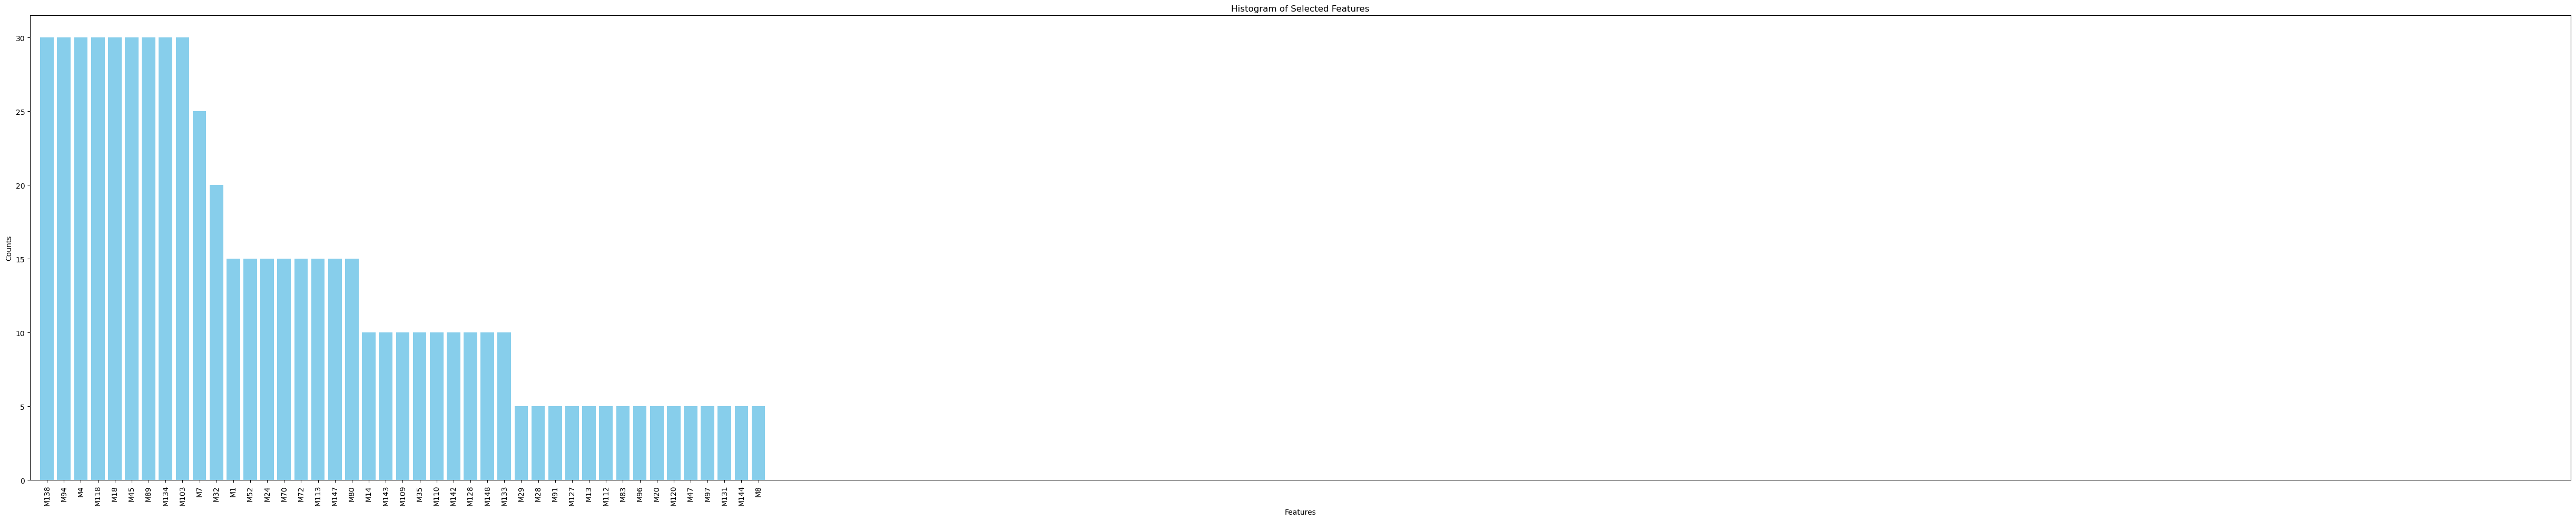

<Figure size 640x480 with 0 Axes>

In [20]:
# eda = DataExplorer(label=label, csv_dir=csv_dir)
# features = eda.statistical_difference(show_box=False)
df = mlpipe.nested_cv(rounds=2,n_trials_ncv=20,outer_splits=3,inner_splits=3,search_on=['LogisticRegression','ElasticNet'],parallel='freely_parallel',return_csv=True,show_bad_samples=True,name_add='manolakos_test',num_features=20)

In [19]:
mod, df  = mlpipe.bayesian_search(estimator_name='LinearDiscriminantAnalysis',scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, warnings_filter=True,calculate_shap=True, training_method='validation_score',processors=5)

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: LinearDiscriminantAnalysis
Best parameters: {'solver': 'lsqr', 'shrinkage': 0.18946457117249252, 'tol': 1e-05, 'store_covariance': True}
Best trials score: 0.5161888794709817.


Bootstrap validation: 100%|██████████| 100/100 [00:01<00:00, 67.79it/s]


In [20]:
df.roc_auc.describe()

count    100.000000
mean       0.787032
std        0.089436
min        0.526786
25%        0.729911
50%        0.800000
75%        0.852778
max        1.000000
Name: roc_auc, dtype: float64

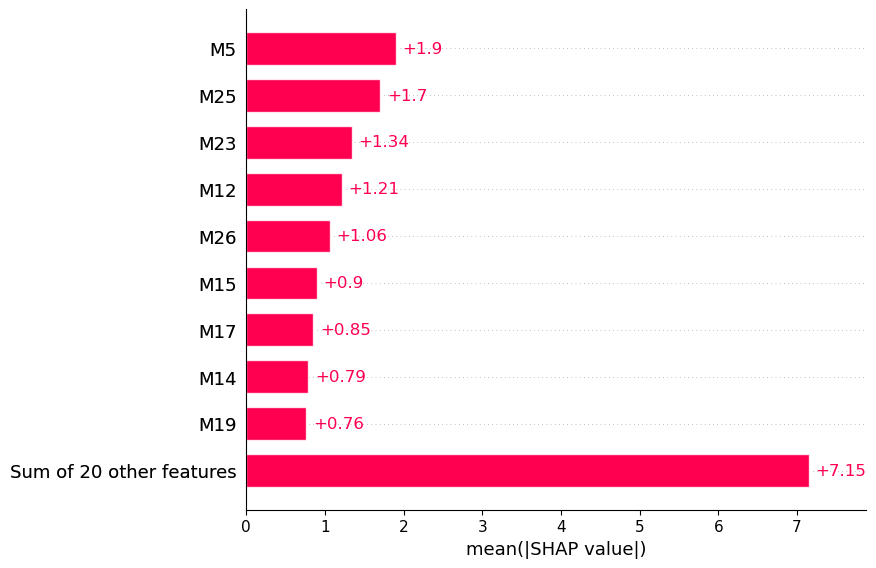

In [21]:
# mod.fit(mlpipe.X, mlpipe.y)
mlexpl = MLExplainer(mod, mlpipe.X, mlpipe.y, mlpipe.label_mapping, shap_values=shp)
# mlexpl.calculate_shap_values(explainer_type='tree')
mlexpl.plot_shap_values(plot_type="bar")

In [44]:
# shap_features = ['942.9824_0.57', '467.3822_23.01', '393.3454_25.66', '613.4767_25.19', '379.3289_23.95','274.2498_23.94','569.4492_25.31'] # epic_lc_ms_pos
# shap_features = ['942.9824_0.57', '393.3454_25.66', '613.4767_25.19', '379.3289_23.95']

# shap_features = ['M25','M14','M66','M7','M52','M58','M34','M55','M63','M64','M33'] # periodontal inflammation

# shap_features = ['M5','M25','M15','M23','M8','M12','M19','M17'] # chronic_fatigue
# shap_features = ['M5','M25','M15','M23','M8','M12']
# shap_features = ['M5','M25','M23','M12','M26']

# shap_features = ['M8','M18','M32'] # gastric cancer

# shap_features = ['M121','M116','M7','M57','M64'] # lung cancer lr

# mlpipe.X=mlpipe.X[shap_features]

In [52]:
mod, df  = mlpipe.bayesian_search(features_names_list=shap_features,estimator_name='LogisticRegression',scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, cv=5, warnings_filter=True,training_method='validation_score',processors=5)
# mod, df  = mlpipe.random_search(estimator_name='ElasticNet',scoring='mathews_corrcoef', evaluation='bootstrap', n_iter=150, cv=5)#,training_method='one_sem')

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: LogisticRegression
Best parameters: {'penalty': None, 'C': 0.46953494666571916, 'solver': 'saga', 'max_iter': 692, 'n_jobs': None}
Best trials score: 0.38844350753502127.


Bootstrap validation: 100%|██████████| 100/100 [00:01<00:00, 72.79it/s]


In [53]:
# df.roc_auc.describe()
import pandas as pd

estimators = ['LogisticRegression','XGBClassifier','SVC','RandomForestClassifier']
con_df = pd.DataFrame()

for estimator in estimators:
    mod, df  = mlpipe.bayesian_search(estimator_name=estimator,scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, cv=5, warnings_filter=True)#,training_method='one_sem')
    df['Training Method'] = 'validation_score'
    df['Dataset'] = csv_dir
    df['Estimator'] = estimator
    df['Features'] = str(shap_features)
    con_df = pd.concat([con_df,df], ignore_index=True)

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: LogisticRegression
Best parameters: {'penalty': None, 'C': 0.5899061095409899, 'solver': 'lbfgs', 'max_iter': 884, 'n_jobs': None}
Best trials score: 0.8419287730781062.


Bootstrap validation: 100%|██████████| 100/100 [00:01<00:00, 75.78it/s]


count    100.000000
mean       0.679859
std        0.097342
min        0.428571
25%        0.629735
50%        0.687500
75%        0.732323
max        0.964286
Name: roc_auc, dtype: float64

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: XGBClassifier
Best parameters: {'learning_rate': 0.08751589716599731, 'n_estimators': 479, 'max_depth': 4, 'subsample': 0.5086830572026867, 'n_jobs': 1, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.29008133561660265, 'reg_lambda': 0.6822567274296311, 'objective': 'binary:logistic', 'eval_metric': 'error'}
Best trials score: 0.814832534780682.


Bootstrap validation: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: SVC
Best parameters: {'C': 0.9931245564135998, 'kernel': 'rbf', 'degree': 9, 'probability': True, 'shrinking': True, 'decision_function_shape': 'ovr'}
Best trials score: 0.8950226126595385.


Bootstrap validation: 100%|██████████| 100/100 [00:00<00:00, 122.64it/s]


Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: RandomForestClassifier
Best parameters: {'n_estimators': 264, 'criterion': 'gini', 'max_depth': 76, 'min_samples_leaf': 2, 'bootstrap': True, 'n_jobs': 1}
Best trials score: 0.8444525250833582.


Bootstrap validation: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


In [6]:
init_df = pd.read_csv('paper_evaluation.csv', index_col=0)
merged_df = pd.concat([init_df, con_df], ignore_index=True)
merged_df

,Scores,mean_test_score,std_test_score,sem_test_score,params,round,ranked,roc_auc,accuracy,balanced_accuracy,recall,precision,f1,matthews_corrcoef,Estimator,Training Method,Dataset,Features
0,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.944444,0.95,0.944444,1.000000,0.916667,0.956522,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
1,0.892143,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.928571,0.95,0.928571,1.000000,0.928571,0.962963,0.892143,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
2,0.811246,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.923077,0.90,0.923077,0.846154,1.000000,0.916667,0.811246,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
3,0.791667,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.895833,0.90,0.895833,0.875000,0.875000,0.875000,0.791667,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
4,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.958333,0.95,0.958333,1.000000,0.888889,0.941176,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,1.000000,0.891134,0.090450,0.009045,NaN,bootstrap,1,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,RandomForestClassifier,validation_score,data/epic_lc_ms_pos.csv,"['942.9824_0.57', '467.3822_23.01', '393.3454_..."
3396,0.902671,0.891134,0.090450,0.009045,NaN,bootstrap,1,0.958333,0.95,0.958333,0.916667,1.000000,0.956522,0.902671,RandomForestClassifier,validation_score,data/epic_lc_ms_pos.csv,"['942.9824_0.57', '467.3822_23.01', '393.3454_..."
3397,0.703526,0.891134,0.090450,0.009045,NaN,bootstrap,1,0.850000,0.85,0.850000,0.800000,0.888889,0.842105,0.703526,RandomForestClassifier,validation_score,data/epic_lc_ms_pos.csv,"['942.9824_0.57', '467.3822_23.01', '393.3454_..."
3398,0.904534,0.891134,0.090450,0.009045,NaN,bootstrap,1,0.950000,0.95,0.950000,1.000000,0.909091,0.952381,0.904534,RandomForestClassifier,validation_score,data/epic_lc_ms_pos.csv,"['942.9824_0.57', '467.3822_23.01', '393.3454_..."


In [7]:
# merged_df = merged_df.dropna(subset=['Estimator'])

merged_df.Estimator.isnull().sum()

0

In [8]:
merged_df.to_csv('paper_evaluation.csv')

In [4]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=2,outer_splits=3,inner_splits=3,inner_selection='one_sem',search_on=['XGBClassifier','CatBoostClassifier'],parallel='freely_parallel',return_csv=True)
# df = mlpipe.nested_cv(plot='box',n_trials_ncv=10,rounds=2,outer_splits=3,inner_splits=3,inner_selection='validation_score',search_on=['ElasticNet','LogisticRegression','XGBClassifier'],return_csv=True)

Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:11:14 ETA:   0:22:28
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:29:56 ETA:   0:59:53
Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:37:29 ETA:   0:18:44
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:37:30 Time:  0:37:30


Finished with 2 round after 0.89 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:41:44 ETA:   0:20:52
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:41:45 Time:  0:41:45


Finished with 1 round after 0.90 hours.
Finished with 2 estimators


Results saved to Results/gastric_cancer_one_sem_all_features_outerloops_results.csv


In [5]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=2,outer_splits=3,inner_splits=3,inner_selection='validation_score',search_on=['XGBClassifier','CatBoostClassifier'],parallel='freely_parallel',return_csv=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:11:03 ETA:   0:22:07
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:21:51 ETA:   0:43:42
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:21:49 ETA:   0:10:54
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:21:50 Time:  0:21:50


Finished with 1 round after 0.60 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:35:36 ETA:   0:17:48
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:35:37 Time:  0:35:37


Finished with 2 round after 0.77 hours.
Finished with 2 estimators


Results saved to Results/gastric_cancer_validation_score_all_features_outerloops_results.csv


In [7]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=3,outer_splits=3,inner_splits=3,inner_selection='gso_1',search_on=['XGBClassifier'],parallel='freely_parallel',return_csv=True,show_bad_samples=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:01:22 ETA:   0:02:44
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:04:02 ETA:   0:02:01
Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:04:03 Time:  0:04:03


Finished with 3 round after 0.09 hours.


Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:02:11 ETA:   0:04:23
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:02:03 ETA:   0:04:06
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:03:48 ETA:   0:01:54
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:03:49 Time:  0:03:49


Finished with 1 round after 0.12 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:03:09 ETA:   0:01:34


Finished with 2 round after 0.13 hours.
Finished with 1 estimators


Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:03:10 Time:  0:03:10


Results saved to Results/gastric_cancer_gso_1_all_features_outerloops_results.csv


In [8]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=3,outer_splits=3,inner_splits=3,inner_selection='gso_2',search_on=['XGBClassifier'],parallel='freely_parallel',return_csv=True,show_bad_samples=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:01:01 ETA:   0:02:03
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:01:15 ETA:   0:02:30
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:01:43 ETA:   0:03:26
Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:02:43 ETA:   0:01:21
Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:02:44 Time:  0:02:44


Finished with 3 round after 0.06 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:03:27 ETA:   0:01:43
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:03:28 Time:  0:03:28


Finished with 2 round after 0.09 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:03:40 ETA:   0:01:50


Finished with 1 round after 0.09 hours.
Finished with 1 estimators


Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:03:41 Time:  0:03:41


Results saved to Results/gastric_cancer_gso_2_all_features_outerloops_results.csv


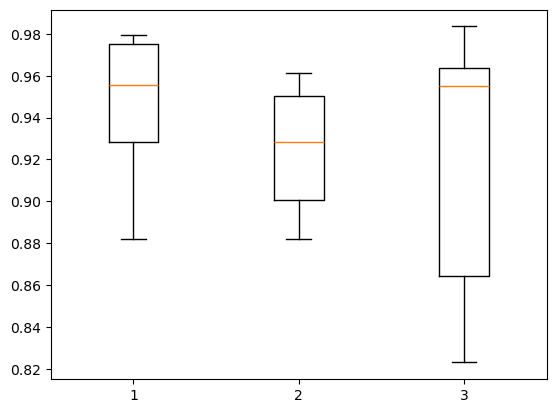

In [26]:
import matplotlib.pyplot as plt
plt.boxplot(df['roc_auc']) #df['roc_auc']
plt.show()

In [4]:
model ,df = mlpipe.bayesian_search(estimator_name='CatBoostClassifier',n_trials=15, missing_values='median')

Normalization completed.


  0%|          | 0/15 [00:00<?, ?it/s]

Estimator: CatBoostClassifier
Best parameters: {'iterations': 90, 'learning_rate': 0.036321151563099195, 'depth': 8, 'l2_leaf_reg': 0.0004417808685331767, 'border_count': 184, 'bagging_temperature': 9.13670134930253, 'random_strength': 9.861153714073298, 'leaf_estimation_method': 'Newton', 'logging_level': 'Silent', 'model_size_reg': 0.31263563587520377, 'rsm': 0.9399807945401994, 'loss_function': None}
Best matthews_corrcoef: 0.7871711623290895


In [46]:
import numpy as np
from scipy.stats import f_oneway, ttest_ind

# Example data: Mean complexity scores for different hyperparameters
important_hyperparams_1 = {
    'max_depth': [0.75],
    'n_estimators': [0.77],
    # 'learning_rate': [0.9]
}

important_hyperparams_2 = {
    'max_depth': [0.85],
    'n_estimators': [0.84],
    # 'learning_rate': [0.8]
}

less_important_hyperparams = {
    'min_samples_leaf': [0.75, 0.78],
    'min_child_weight': [0.74, 0.77],
    'gamma': [0.76, 0.79]
}

# Calculate means
important_means_1 = np.mean([np.mean(scores) for scores in important_hyperparams_1.values()])
important_means_2 = np.mean([np.mean(scores) for scores in important_hyperparams_2.values()])

# less_important_means = [np.mean(scores) for scores in less_important_hyperparams.values()]

print(f"Parameter 1: {important_means_1}, Parameter 2: {important_means_2}, Parameter Difference: {important_means_1 - important_means_2}")

Parameter 1: 0.76, Parameter 2: 0.845, Parameter Difference: -0.08499999999999996


In [13]:
samples_counts = np.zeros(10)
samples_counts[3] +=1
samples_counts

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [9]:
import numpy as np

In [14]:
for i in samples_counts:
    print(i)

0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
import optuna
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from optuna.integration import OptunaSearchCV
from sklearn.metrics import accuracy_score

# Load data
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple model
model = SVC()

# Create a parameter distribution dictionary
param_distributions = {
    'C': optuna.distributions.FloatDistribution(0.01, 1),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(0.01, 1)
}

# Setup OptunaSearchCV
optuna_search = OptunaSearchCV(
    model,
    param_distributions,
    cv=3,
    return_train_score=True,
    n_trials=100,  # Number of trials to conduct
    timeout=600,   # Stop study after 600 seconds
    n_jobs=-1      # Use all available CPUs
)

# Fit the OptunaSearchCV to find the best hyperparameters
optuna_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", optuna_search.best_params_)

# Predict using the best model
predictions = optuna_search.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


[I 2024-07-05 21:51:04,057] A new study created in memory with name: no-name-f478a1a8-74bc-4773-a5dc-40e5b3723cf3
[I 2024-07-05 21:51:04,149] Trial 1 finished with value: 0.9500000000000001 and parameters: {'C': 0.5295357139760623, 'kernel': 'rbf', 'gamma': 0.36190732697212463}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,172] Trial 4 finished with value: 0.9416666666666668 and parameters: {'C': 0.20592782276453386, 'kernel': 'poly', 'gamma': 0.9612114538483573}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,178] Trial 0 finished with value: 0.7333333333333334 and parameters: {'C': 0.2902145176469904, 'kernel': 'rbf', 'gamma': 0.013237285050805424}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,184] Trial 5 finished with value: 0.325 and parameters: {'C': 0.9336066846146562, 'kernel': 'sigmoid', 'gamma': 0.7082614051302398}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,193] Trial 6 fi

Best parameters: {'C': 0.9349413205484218, 'kernel': 'linear', 'gamma': 0.11900378926516163}
Accuracy: 1.0


In [9]:
optuna_search.trials_


[FrozenTrial(number=0, state=1, values=[0.7333333333333334], datetime_start=datetime.datetime(2024, 7, 5, 21, 51, 4, 60412), datetime_complete=datetime.datetime(2024, 7, 5, 21, 51, 4, 178575), params={'C': 0.2902145176469904, 'kernel': 'rbf', 'gamma': 0.013237285050805424}, user_attrs={'mean_fit_time': 0.017210642496744793, 'std_fit_time': 0.008458070571432984, 'mean_score_time': 0.006486733754475911, 'std_score_time': 0.004938715149793585, 'split0_test_score': 0.775, 'split1_test_score': 0.7, 'split2_test_score': 0.725, 'mean_test_score': 0.7333333333333334, 'std_test_score': 0.031180478223116204, 'split0_train_score': 0.7, 'split1_train_score': 0.75, 'split2_train_score': 0.7375, 'mean_train_score': 0.7291666666666666, 'std_train_score': 0.021245914639969964}, system_attrs={'terminator:cv_scores': [0.775, 0.7, 0.725]}, intermediate_values={}, distributions={'C': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'kernel': CategoricalDistribution(choices=('linear', 'poly', '